# **Data Inspection with Autoencoders**

## ⚙️ Import Libraries

In [15]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)


from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd


# Configure plot display settings
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

2.16.1


## ⏳ Load and Process Data

In [16]:
import numpy as np

data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

In [17]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

INPUT_SHAPE = X_train.shape[1:]
NUM_CLASSES = len(np.unique(y_train))

print(f"Input shape: {INPUT_SHAPE}")
print(f"Number of classes: {NUM_CLASSES}")

Input shape: (64, 128, 1)
Number of classes: 5


In [18]:
train_img, val_img, train_lbl, val_lbl = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=seed
)

print('Data splitted!')

print(f'\nNumber of images:')
print(f'Train: {len(train_img)}')
print(f'Validation: {len(val_img)}')
print(f'Test: {len(X_test)}')

print('\nShapes:')
print(f'Train Data Shape: {train_img.shape}')
print(f'Train Masks Shape: {train_lbl.shape} ')
print(f'Validation Data Shape: {val_img.shape}')
print(f'Validation Masks Shape: {val_img.shape}')
print(f'Test Data Shape: {X_test.shape}')

Data splitted!

Number of images:
Train: 2092
Validation: 523
Test: 10022

Shapes:
Train Data Shape: (2092, 64, 128, 1)
Train Masks Shape: (2092, 64, 128) 
Validation Data Shape: (523, 64, 128, 1)
Validation Masks Shape: (523, 64, 128, 1)
Test Data Shape: (10022, 64, 128, 1)


In [19]:
# Define the latent dimension for dimensionality reduction or feature extraction
LATENT_DIM = 2

# Set batch size for training
BATCH_SIZE = 128

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set maximum number of training epochs
EPOCHS = 1000

# Print the configurations to verify their correctness
print(f'Input shape: {INPUT_SHAPE}')
print(f'Latent dimension: {LATENT_DIM}')
print(f'Learning rate: {LEARNING_RATE}')
print(f'Batch size: {BATCH_SIZE}')
print(f'Epochs: {EPOCHS}')

Input shape: (64, 128, 1)
Latent dimension: 2
Learning rate: 0.001
Batch size: 128
Epochs: 1000


## 🛠️ Build and Train the Autoencoder

In [20]:
# The ENCODER has the goal of compressing data

def get_encoder(enc_input_shape=INPUT_SHAPE, enc_output_shape=LATENT_DIM, seed=seed):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Define the Input Layer with the specified shape
    input_layer = tfkl.Input(shape=enc_input_shape, name='input_layer')

    # First Convolution Block
    x = tfkl.Conv2D(32, 3, 2, padding='same')(input_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Second Convolution Block
    x = tfkl.Conv2D(64, 3, 2, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Third Convolution Block
    x = tfkl.Conv2D(128, 3, 2, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Flatten the output of the last convolution layer
    x = tfkl.Flatten()(x)
    # Define the output layer with the specified output shape
    output_layer = tfkl.Dense(enc_output_shape, name='output_layer')(x)

    # Create the Model linking input and output
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='encoder')

    return model

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 64, 128, 1)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_14 (Conv2D)          │ (None, 32, 64, 32)    │        320 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_14      │ (None, 32, 64, 32)    │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_14 (LeakyReLU)  │ (None, 32, 64, 32)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_15 (Conv2D)          │ (None, 16, 32, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_15      │ (None, 16, 32, 64)    │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_15 (LeakyReLU)  │ (None, 16, 32, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_16 (Conv2D)          │ (None, 8, 16, 128)    │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_16      │ (None, 8, 16, 128)    │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_16 (LeakyReLU)  │ (None, 8, 16, 128)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten_2 (Flatten)         │ (None, 16384)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ output_layer (Dense)        │ (None, 2)             │     32,770 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 126,338 (493.51 KB)

 Trainable params: 125,890 (491.76 KB)

 Non-trainable params: 448 (1.75 KB)

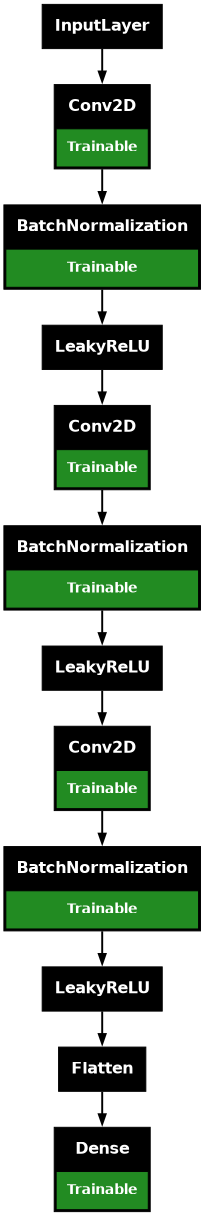

In [21]:
encoder = get_encoder()

# Print a detailed summary of the encoder with expanded nested layers and trainable parameters.
encoder.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the encoder architecture.
tf.keras.utils.plot_model(encoder, show_trainable=True, expand_nested=True, dpi=70)

In [22]:
def get_decoder(dec_input_shape=(LATENT_DIM,), dec_output_shape=INPUT_SHAPE, seed=seed):
    # Set the random seed for reproducibility
    tf.random.set_seed(seed)

    # Define the Input Layer with the specified shape
    input_layer = tfkl.Input(shape=dec_input_shape, name='input_layer')

    # Start the Decoder Network with a Dense Layer
    # and reshape into the desired initial convolutional shape
    x = tfkl.Dense(8*16*128)(input_layer)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)
    x = tfkl.Reshape((8, 16, 128))(x)

    # First Upsampling and Convolution Block
    x = tfkl.UpSampling2D(interpolation='bilinear')(x)
    x = tfkl.Conv2D(128, 3, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Second Upsampling and Convolution Block
    x = tfkl.UpSampling2D(interpolation='bilinear')(x)
    x = tfkl.Conv2D(64, 3, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Third Upsampling and Convolution Block
    x = tfkl.UpSampling2D(interpolation='bilinear')(x)
    x = tfkl.Conv2D(32, 3, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.LeakyReLU()(x)

    # Apply a final convolution with the number of channels equal to the original image depth
    x = tfkl.Conv2D(dec_output_shape[-1], 3, padding='same')(x)

    # Sigmoid Activation to ensure output values between 0 and 1
    output_layer = tfkl.Activation('sigmoid')(x)

    # Connect Input and Output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='decoder')

    return model

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 2)             │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 16384)         │     49,152 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_17      │ (None, 16384)         │     65,536 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_17 (LeakyReLU)  │ (None, 16384)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ reshape_2 (Reshape)         │ (None, 8, 16, 128)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ up_sampling2d_6             │ (None, 16, 32, 128)   │          0 │   -   │
│ (UpSampling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_17 (Conv2D)          │ (None, 16, 32, 128)   │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_18      │ (None, 16, 32, 128)   │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_18 (LeakyReLU)  │ (None, 16, 32, 128)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ up_sampling2d_7             │ (None, 32, 64, 128)   │          0 │   -   │
│ (UpSampling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_18 (Conv2D)          │ (None, 32, 64, 64)    │     73,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_19      │ (None, 32, 64, 64)    │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_19 (LeakyReLU)  │ (None, 32, 64, 64)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ up_sampling2d_8             │ (None, 64, 128, 64)   │          0 │   -   │
│ (UpSampling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_19 (Conv2D)          │ (None, 64, 128, 32)   │     18,464 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ batch_normalization_20      │ (None, 64, 128, 32)   │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ leaky_re_lu_20 (LeakyReLU)  │ (None, 64, 128, 32)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_20 (Conv2D)          │ (None, 64, 128, 1)    │        289 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ activation_2 (Activation)   │ (None, 64, 128, 1)    │          0 │   -   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 355,713 (1.36 MB)

 Trainable params: 322,497 (1.23 MB)

 Non-trainable params: 33,216 (129.75 KB)

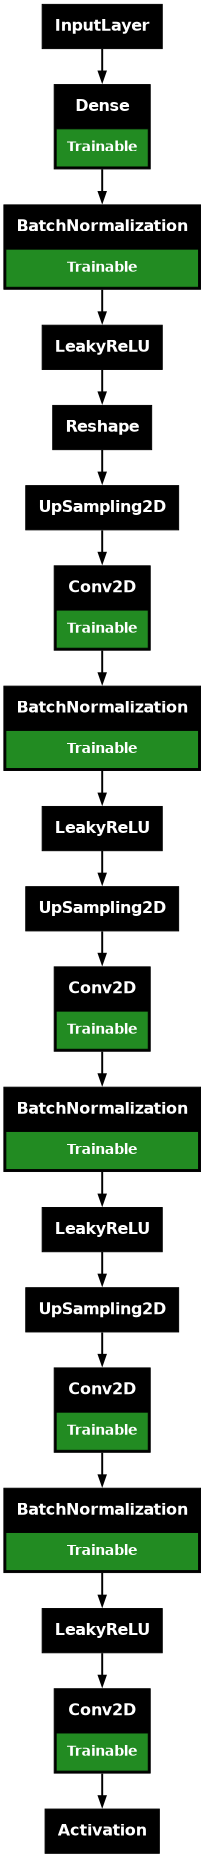

In [23]:
decoder = get_decoder()

# Print a detailed summary of the decoder with expanded nested layers and trainable parameters.
decoder.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the decoder architecture.
tf.keras.utils.plot_model(decoder, show_trainable=True, expand_nested=True, dpi=70)

In [24]:
def get_autoencoder(ae_input_shape=INPUT_SHAPE, ae_output_shape=INPUT_SHAPE):
    # Set the random seed to ensure reproducibility
    tf.random.set_seed(seed)

    # Initialize the encoder and decoder models
    encoder = get_encoder()
    decoder = get_decoder()

    # Define the input layer
    input_layer = tfkl.Input(shape=ae_input_shape)

    # Pass input through the encoder to get the compressed representation
    z = encoder(input_layer)

    # Pass the representation through the decoder to reconstruct the input
    output_layer = decoder(z)

    # Create the autoencoder model
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='autoencoder')
    return model

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 64, 128, 1)    │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ encoder (Functional)        │ (None, 2)             │    126,338 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer            │ (None, 64, 128, 1)    │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv2d_21 (Conv2D)     │ (None, 32, 64, 32)    │        320 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ batch_normalization_21 │ (None, 32, 64, 32)    │        128 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ leaky_re_lu_21         │ (None, 32, 64, 32)    │          0 │   -   │
│ (LeakyReLU)                 │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv2d_22 (Conv2D)     │ (None, 16, 32, 64)    │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ batch_normalization_22 │ (None, 16, 32, 64)    │        256 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ leaky_re_lu_22         │ (None, 16, 32, 64)    │          0 │   -   │
│ (LeakyReLU)                 │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ conv2d_23 (Conv2D)     │ (None, 8, 16, 128)    │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ batch_normalization_23 │ (None, 8, 16, 128)    │        512 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ leaky_re_lu_23         │ (None, 8, 16, 128)    │          0 │   -   │
│ (LeakyReLU)                 │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ flatten_3 (Flatten)    │ (None, 16384)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ output_layer (Dense)   │ (None, 2)             │     32,770 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ decoder (Functional)        │ (None, 64, 128, 1)    │    355,713 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ input_layer            │ (None, 2)             │          0 │   -   │
│ (InputLayer)                │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ dense_3 (Dense)        │ (None, 16384)         │     49,152 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ batch_normalization_24 │ (None, 16384)         │     65,536 │   Y   │
│ (BatchNormalization)        │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ leaky_re_lu_24         │ (None, 16384)         │          0 │   -   │
│ (LeakyReLU)                 │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│    └ reshape_3 (Reshape)    │ (None, 8, 16, 128)    │          0 │   - 

 Total params: 482,051 (1.84 MB)

 Trainable params: 448,387 (1.71 MB)

 Non-trainable params: 33,664 (131.50 KB)

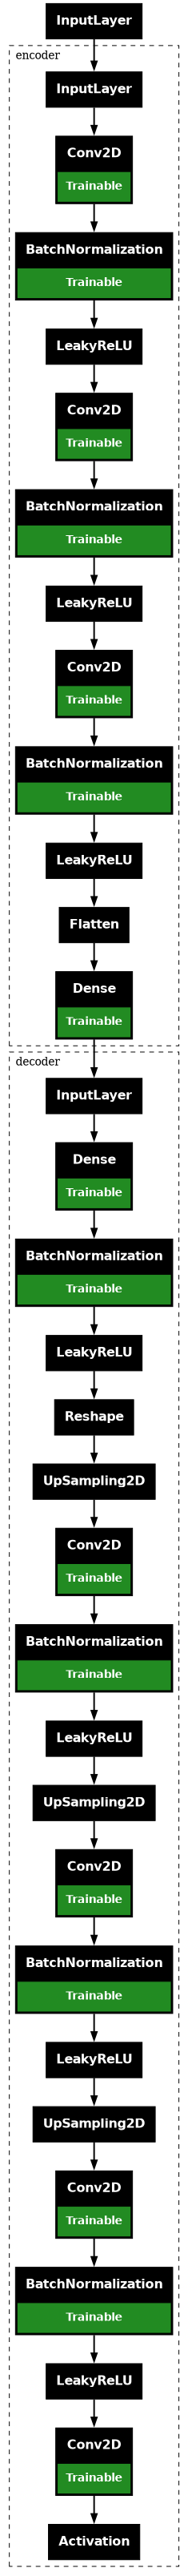

In [25]:
autoencoder = get_autoencoder()

# Print a detailed summary of the autoencoder with expanded nested layers and trainable parameters.
autoencoder.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the autoencoder architecture.
tf.keras.utils.plot_model(autoencoder, show_trainable=True, expand_nested=True, dpi=70)

In [26]:
# Initialize the optimizer with the defined learning rate
optimizer = tf.optimizers.Adam(LEARNING_RATE)

# Compile the autoencoder with Adam optimizer and mean squared error loss
autoencoder.compile(optimizer=optimizer, loss=tfk.losses.MeanSquaredError())

In [27]:
# Train the autoencoder model
history = autoencoder.fit(
    train_img,
    train_img,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_img, val_img),
    callbacks=[
        tfk.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.1, min_lr=1e-4),
    ],
    verbose=1
).history

# Calculate and print the final validation loss
final_val_loss = round(min(history['val_loss']), 4)
print(f'Final validation loss: {final_val_loss}')

# Save the trained model to a file with the loss included in the filename
model_filename = f'autoencoder_{final_val_loss}.keras'
autoencoder.save(model_filename)

# Delete the model to free up resources
#del autoencoder

Epoch 1/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 12s 382ms/step - loss: 0.0562 - val_loss: 0.0309 - learning_rate: 0.0010
Epoch 2/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 175ms/step - loss: 0.0057 - val_loss: 0.0201 - learning_rate: 0.0010
Epoch 3/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 177ms/step - loss: 0.0052 - val_loss: 0.0165 - learning_rate: 0.0010
Epoch 4/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 181ms/step - loss: 0.0047 - val_loss: 0.0146 - learning_rate: 0.0010
Epoch 5/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 182ms/step - loss: 0.0043 - val_loss: 0.0136 - learning_rate: 0.0010
Epoch 6/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 183ms/step - loss: 0.0043 - val_loss: 0.0131 - learning_rate: 0.0010
Epoch 7/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step - loss: 0.0043 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 8/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.0042 - val_loss: 0.0123 - learning_rate: 0.0010
Epoch 9/1000
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.0042 - val_loss: 0.0120 - learning_rate

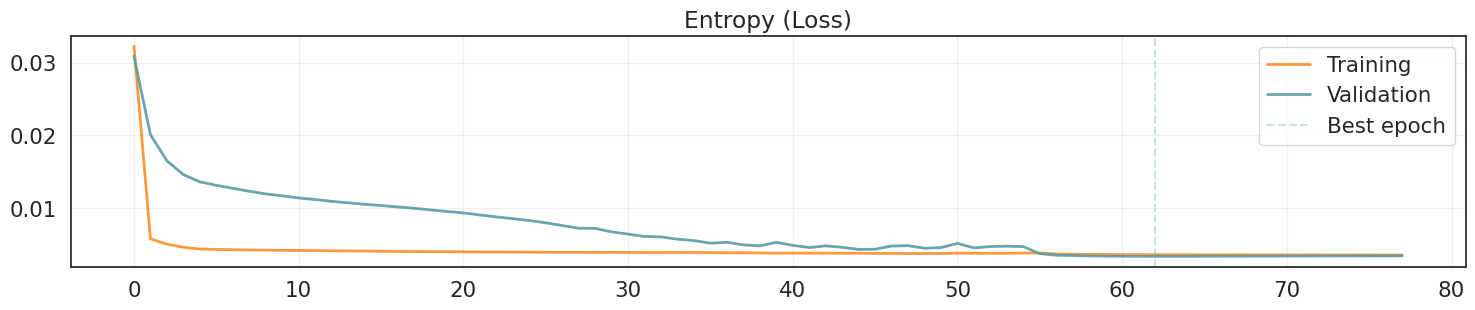

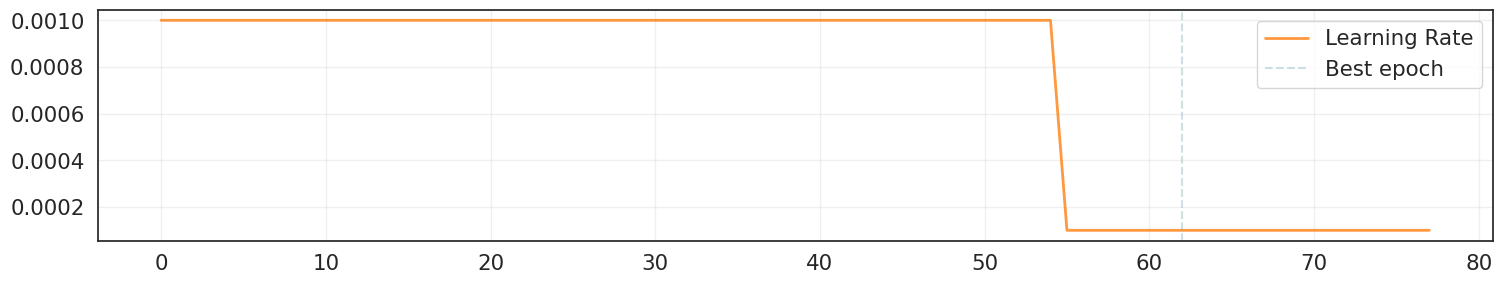

In [28]:
# Identify the best epoch based on minimum validation loss
best_epoch = np.argmin(history['val_loss'])

# Plot training and validation loss
plt.figure(figsize=(18,3))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=.9, color='#5a9aa5', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Entropy (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

# Plot learning rate
plt.figure(figsize=(18,3))
plt.plot(history['learning_rate'], label='Learning Rate', alpha=.8, color='#ff7f0e', linewidth=2)
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

## 🕹️ Use the Model - Make Inference

In [29]:
# Extract the encoder component from the autoencoder
encoder = autoencoder.get_layer('encoder')

# Extract the decoder component from the autoencoder
decoder = autoencoder.get_layer('decoder')

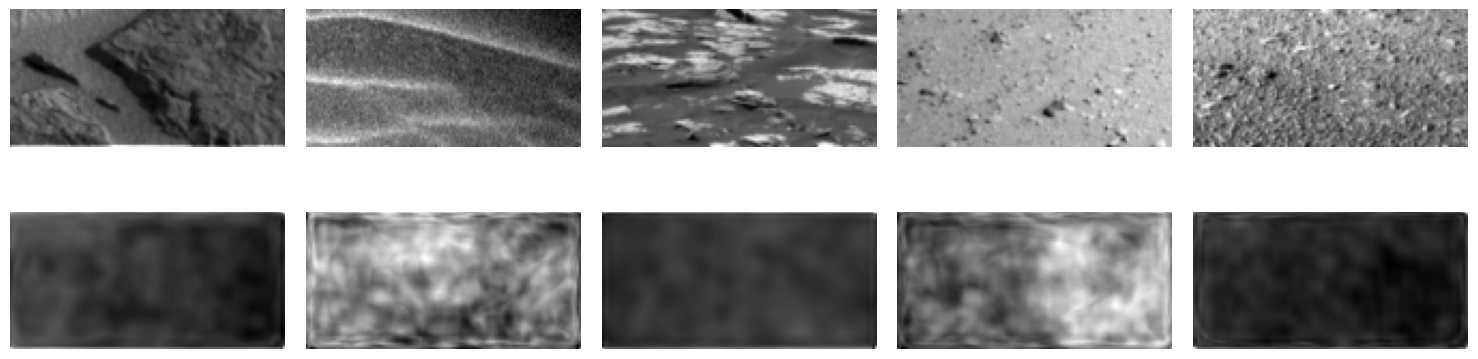

In [36]:
# Configuration and model prediction
num_col = 5
predictions = autoencoder.predict(X_test[:num_col], verbose=0)

# Set up plot dimensions
fig, axes = plt.subplots(2, num_col, figsize=(15, 5))

# Loop through the grid and populate subplots
for i in range(num_col * 2):
    ax = axes[i // num_col, i % num_col]
    ax.axis('off')

    # Display original images on the top row
    if i < num_col:
        ax.imshow(np.squeeze(X_test[i]), cmap='gray')
        #ax.set_title(f'Original: {y_test[i]}', fontsize=10)

    # Display reconstructed images on subsequent rows
    else:
        ax.imshow(np.squeeze(predictions[i - num_col]), cmap='gray')
        #ax.set_title(f'Reconstructed: {y_test[i - num_col]}', fontsize=10)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

Text(0, 0.5, 't-SNE 2')

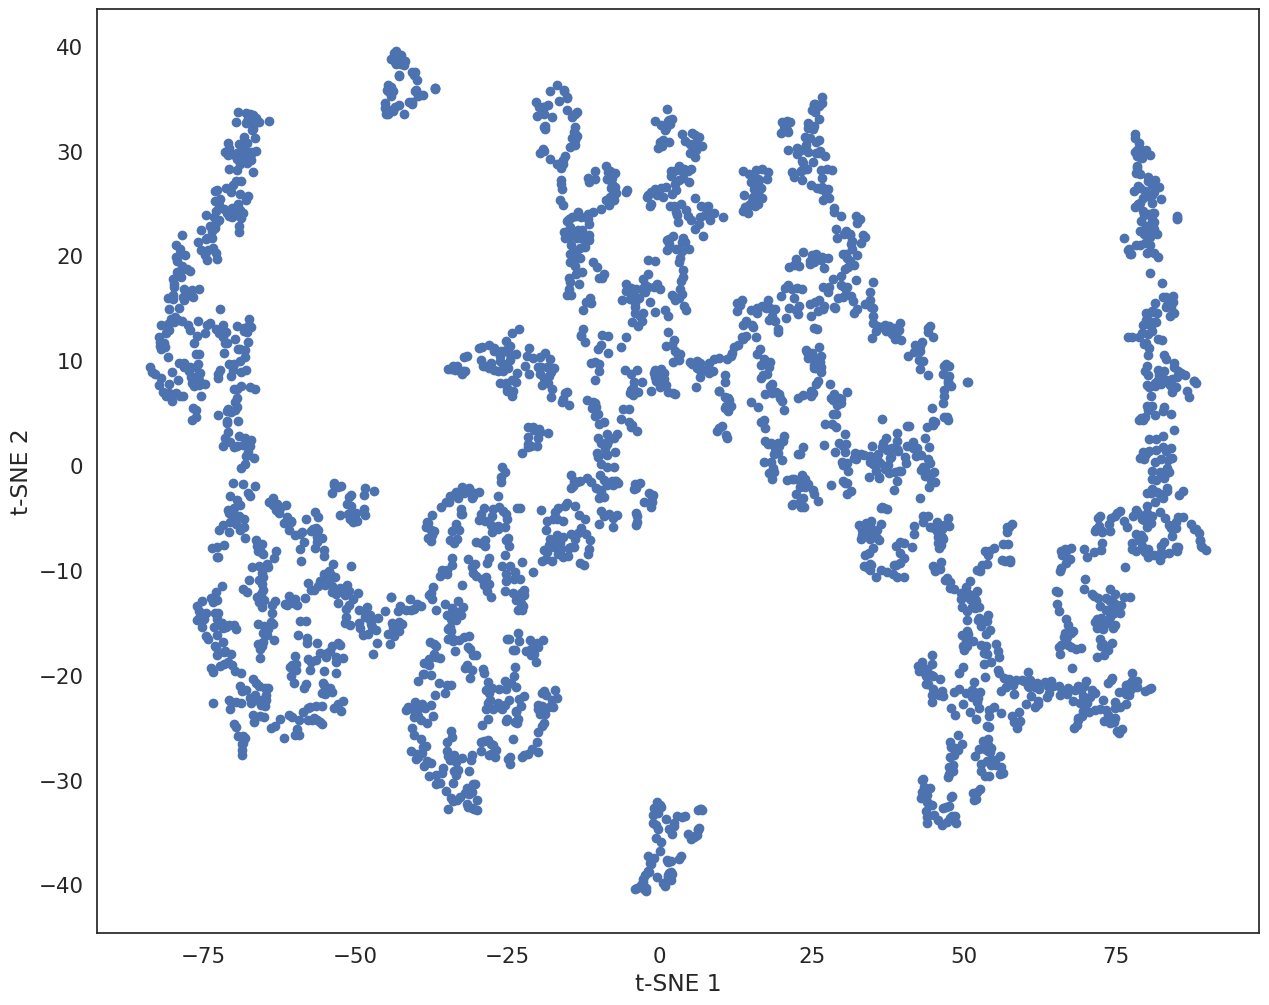

In [52]:
z_mean = encoder.predict(X_train, verbose=0)

# Apply TSNE for Dimensionality Reduction
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
tsne_features = tsne.fit_transform(z_mean)

plt.figure(figsize=(15, 12))
plt.scatter(tsne_features[:, 0], tsne_features[:, 1], cmap='viridis')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')